In [1]:
import numpy as np
from qutip import *
import dask
from dask import delayed
import dask.bag as db
from dask.distributed import Client, LocalCluster,progress
from tqdm import tqdm
import importlib
import functions_fbq
importlib.reload(functions_fbq)
from functions_fbq import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from figurestyle import *
figure_features()
# refresh the functions_fbq.py file if it has been changed
# %load_ext autoreload
# %autoreload 2

In [32]:
# Crear un clúster local de Dask y un cliente para conectarse a él
cluster = LocalCluster(n_workers=20, threads_per_worker=1)
client = Client(cluster)

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:64216
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64238'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64221'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64234'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64227'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64226'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64231'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64228'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64222'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64229'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64224'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64225'
INFO:distributed.nanny:        Start Nanny

In [33]:
Ec = 40e9
EDelta = 20e9
eigvals = 2
phi_ext = np.pi

El_list = 5 * 1e9 * np.logspace(-2, 1, 60)
r_list = np.linspace(0.05, 0.95, 60)
El_r_pairs = [(El, r) for El in El_list for r in r_list]

phi_matrix_elements_list = np.zeros((len(El_list), len(r_list)))
n_matrix_elements_list = np.zeros((len(El_list), len(r_list)))
dHdr_matrix_elements_list = np.zeros((len(El_list), len(r_list)))
d2E01dphi2_list = np.zeros((len(El_list), len(r_list)))

In [34]:
@delayed
def process_r(El, r):
    eigvals_list, _, matrix_op_sqr_list = eigensystem_and_matrix_elements_Josephson(Ec, El, EDelta, phi_ext, r,100, eigvals)
    phi_matrix_element = matrix_op_sqr_list[0]
    n_matrix_element = matrix_op_sqr_list[1]
    dH_dr_element = matrix_op_sqr_list[2]

    phi_ext_list = np.linspace(phi_ext, phi_ext +0.1, 10)
    eigvals_list = np.array([np.real(eigensystem_and_matrix_elements_Josephson(Ec, El, EDelta, phi_ext_aux, r, N = 100, eigvals = 2)[0][1] - eigensystem_and_matrix_elements_sqr_fbq(Ec, El, EDelta, 0, r, N = 50, eigvals = 2)[0][0]) for phi_ext_aux in phi_ext_list])

    phi_ext_list = np.concatenate([-phi_ext_list[::-1][0:-1], phi_ext_list])
    eigvals_list = np.concatenate([eigvals_list[::-1][0:-1], eigvals_list])

    dE01_dphi = np.gradient(eigvals_list, phi_ext_list, edge_order=1)
    d2E01_dphi2 = np.gradient(dE01_dphi, phi_ext_list, edge_order=1)
    d2E01dphi2 = d2E01_dphi2[len(phi_ext_list) // 2]

    return phi_matrix_element, n_matrix_element, dH_dr_element, d2E01dphi2


In [54]:
futures = client.map(process_r, El_r_pairs)  # Reemplaza 'func' por tu función y 'data' por tus datos
results = client.gather(futures)
progress(futures)

VBox()

In [35]:
# Crear un dask bag a partir de la lista de tuplas y mapear la función process_r
results_bag = db.from_sequence(El_r_pairs).map(lambda x: process_r(x[0], x[1]))

# Calcular los resultados
computed_results = dask.compute(*results_bag)

# Asignar los resultados a las matrices correspondientes
k = 0
for i, El in enumerate(El_list):
    for j, r in enumerate(r_list):
        phi_matrix_element, n_matrix_element, dH_dr_element, d2E01dphi2 = computed_results[k]
        phi_matrix_elements_list[i, j] = El * np.abs(phi_matrix_element)
        n_matrix_elements_list[i, j] = 8 * Ec * np.abs(n_matrix_element)
        dHdr_matrix_elements_list[i, j] = np.abs(dH_dr_element)
        d2E01dphi2_list[i, j] = np.abs(d2E01dphi2)
        k += 1


In [1]:
client.close()
cluster.close()

NameError: name 'client' is not defined

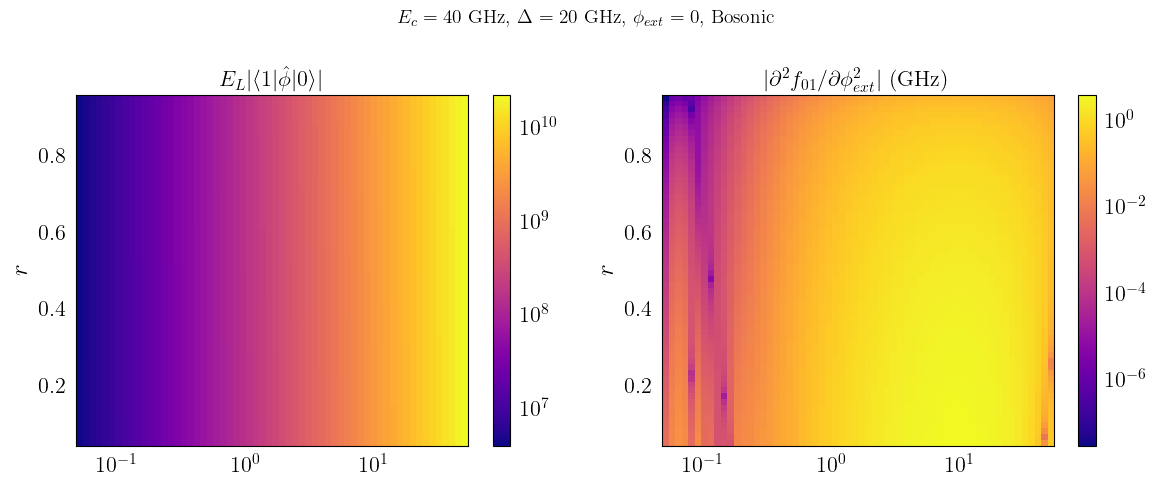

In [30]:
# Escala logarítmica para los colores
norm = colors.LogNorm()
norm2 = colors.LogNorm()
norm3 = colors.LogNorm()
El_mesh, r_mesh = np.meshgrid(El_list, r_list, indexing="ij")
# Graficar phi_matrix_elements_list vs El y r
fig1, ax = plt.subplots(1,2, figsize =(12,5), sharex=True)

# put a title with the parameters values
fig1.suptitle(r"$E_c = 40$ GHz, $\Delta = 20$ GHz, $\phi_{ext} = 0$, Bosonic", fontsize=14)
contour1 = ax[0].pcolormesh(El_mesh / 1e9, r_mesh, phi_matrix_elements_list, cmap="plasma", norm=norm)
ax[0].set_xscale("log")
# ax[0].set_yscale("log")
# ax[0].set_xlabel(r"$E_L$ (GHz)")
ax[0].set_ylabel(r"$r$")
ax[0].set_title(r"$E_L | \langle 1 | \hat{\phi} | 0 \rangle|$")
fig1.colorbar(contour1, ax=ax[0])

# Graficar d2E01dphi2_list vs El y r
contour2 = ax[1].pcolormesh(El_mesh / 1e9, r_mesh, np.abs(d2E01dphi2_list)*1e-9, cmap="plasma", norm=norm2)
ax[1].set_xscale("log")
# ax[1].set_yscale("log")
# ax[1].set_xlabel(r"$E_L$ (GHz)")
ax[1].set_ylabel(r"$r$")
ax[1].set_title(r"$| \partial^2 f_{01} /\partial \phi_{ext}^2|$ (GHz)")
fig1.colorbar(contour2, ax=ax[1])

# Graficar dHdr_matrix_elements_list vs El y r
# contour3 = ax[2].pcolormesh(El_mesh / 1e9, r_mesh, n_matrix_elements_list*1e-9, cmap="plasma",norm=norm3)
# ax[2].set_xscale("log")
# # ax[2].set_yscale("log")
# ax[2].set_xlabel(r"$E_L$ (GHz)")
# ax[2].set_ylabel(r"$r$")
# ax[2].set_title(r"$8 E_C | \langle 1 | \hat{n} | 0 \rangle|$ (GHz)")
# fig1.colorbar(contour3, ax=ax[2])

plt.tight_layout()
plt.savefig("r_El_sweep_Ec_40GHz_EDelta_20GHz_phi_ext_0_bosonic.pdf")

plt.show()



In [31]:
with open("E_l_r_sweep_matrix_element_d2f01dphi2_phi_ext_0_bosonic.dat", "w") as file:
    file.write("# El\t r\t phi_matrix_elements_list\t d2E01dphi2_list\n")
    for i, El in enumerate(El_list):
        for j, r in enumerate(r_list):
            phi_matrix_element2 = phi_matrix_elements_list[i, j]
            d2E01dphi2_1 = d2E01dphi2_list[i, j]
            file.write(f"{El}\t{r}\t{phi_matrix_element2}\t{d2E01dphi2_1}\n")